In [1]:
%matplotlib ipympl
#%matplotlib widget
#%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyobs
import bison

# plt.rcParams.update({
#     "text.usetex"      : True,
#     "font.family"      : "Helvetica",
#     "mathtext.fontset" : "dejavuserif"
# })
plt.rcParams.update({
    "axes.axisbelow"   : True,
})

In [2]:
### Data file ###
data = bison.load("Cnfgs_measurement/WF-slices_beta617_seed123456.dat")
print(data.keys())
print(data['Configuration 40'].keys())
print(data['Configuration 40']['Q'].shape)
print(data['MC History tag-1']['dH'].shape)
print(data['MC History tag-1']['Acc/Rej'].shape)

[Bison] : Reading file Cnfgs_measurement/WF-slices_beta617_seed123456.dat
[Bison] : File created by gmorandi at ampere on Tue Dec 19 00:02:04 2023
[Bison] : Read 57.4873 MB at 109.49 MB/s
dict_keys(['beta coupling', 'Lattice', 'Number of steps of OMF4 integrator', 'Length of each MD trajectory', 'MD trajectories', 'MC measure step', 'epsilon WF', 'WF evolutions from t = 0', 'WF measure step', 'Configuration 1', 'Configuration 2', 'Configuration 3', 'Configuration 4', 'Configuration 5', 'Configuration 6', 'Configuration 7', 'Configuration 8', 'Configuration 9', 'Configuration 10', 'Configuration 11', 'Configuration 12', 'Configuration 13', 'Configuration 14', 'Configuration 15', 'Configuration 16', 'Configuration 17', 'Configuration 18', 'Configuration 19', 'Configuration 20', 'MC History tag-0', 'Configuration 21', 'Configuration 22', 'Configuration 23', 'Configuration 24', 'Configuration 25', 'Configuration 26', 'Configuration 27', 'Configuration 28', 'Configuration 29', 'Configuratio

In [3]:
##############################
### General run parameters ###
##############################
beta      =  data['beta coupling']
L1, L2, L3, T = data['Lattice']
V         =  L1 * L2 * L3 * T
D         =  4
Ns        =  data['Number of steps of OMF4 integrator']
tauMD     =  data['Length of each MD trajectory']
Ntraj     =  data['MD trajectories']
MC_step   =  data['MC measure step']
eps_WF    =  data['epsilon WF']
WF_evol   =  data['WF evolutions from t = 0']
WF_step   =  data['WF measure step']
Nwf       =  WF_evol // WF_step + 1
Nc_run    = Ntraj // MC_step

Ncnfg = 0
Nh    = 0
for key in data:
    if key.startswith('Configuration'):
        Ncnfg += 1
    if key.startswith('MC History'):
        Nh += 1


print(f"\n Lattice                =  [{L1}x{L2}x{L3}x{T}]")
print(f" Lattice volume         =  {V}")
print(f" beta                   =  {beta}")
print(f" Steps of OMF4          =  {Ns}")
print(f" tau MD                 =  {tauMD}")
print(f" MD trajectories        =  {Ntraj}")
print(f" MC interval between measurements  =  {MC_step}")
print(f" epsilon of Wilson Flow =  {eps_WF}")
print(f" Wilson Flow evolutions =  {WF_evol}")
print(f" Wilson Flow steps between measurements =  {WF_step}\n")

print(f" Measured flow times:")
print(*(f" t = {eps_WF * WF_step * i:.2f}" for i in range(Nwf)), sep='\n')

print(f"\n Total number of measurements = {Ncnfg}, extracted from {Nh} runs, {Nc_run} meas. each.")
print(f" Total number of configurations = {int(Ncnfg * tauMD * MC_step)} MDU")
print(f" Preliminary thermalization trajectories = 200, i.e. {int(200 * tauMD)} MDU")
print(f" we should reach 5 x max(tau_int) [MDU], namely ~ {5 * MC_step * 20} MDU")


 Lattice                =  [32x32x32x64]
 Lattice volume         =  2097152
 beta                   =  6.17
 Steps of OMF4          =  8
 tau MD                 =  2.0
 MD trajectories        =  200
 MC interval between measurements  =  10
 epsilon of Wilson Flow =  0.02
 Wilson Flow evolutions =  300
 Wilson Flow steps between measurements =  5

 Measured flow times:
 t = 0.00
 t = 0.10
 t = 0.20
 t = 0.30
 t = 0.40
 t = 0.50
 t = 0.60
 t = 0.70
 t = 0.80
 t = 0.90
 t = 1.00
 t = 1.10
 t = 1.20
 t = 1.30
 t = 1.40
 t = 1.50
 t = 1.60
 t = 1.70
 t = 1.80
 t = 1.90
 t = 2.00
 t = 2.10
 t = 2.20
 t = 2.30
 t = 2.40
 t = 2.50
 t = 2.60
 t = 2.70
 t = 2.80
 t = 2.90
 t = 3.00
 t = 3.10
 t = 3.20
 t = 3.30
 t = 3.40
 t = 3.50
 t = 3.60
 t = 3.70
 t = 3.80
 t = 3.90
 t = 4.00
 t = 4.10
 t = 4.20
 t = 4.30
 t = 4.40
 t = 4.50
 t = 4.60
 t = 4.70
 t = 4.80
 t = 4.90
 t = 5.00
 t = 5.10
 t = 5.20
 t = 5.30
 t = 5.40
 t = 5.50
 t = 5.60
 t = 5.70
 t = 5.80
 t = 5.90
 t = 6.00

 Total number of 

In [4]:
########################################################
### Loading history run and observables measurements ###
########################################################
WF_EClov = np.zeros((Ncnfg, Nwf, T))
WF_Plaq  = np.zeros((Ncnfg, Nwf, T))
WF_Q     = np.zeros((Ncnfg, Nwf, T))
Acc      = np.zeros((Nh * Ntraj)) 
dH       = np.zeros((Nh * Ntraj))

for i in range(Ncnfg):
    WF_EClov[i,:,:] = data[f'Configuration {i+1}']['E_Clov']
    WF_Plaq[i,:,:]  = data[f'Configuration {i+1}']['Plaquette']
    WF_Q[i,:,:]     = data[f'Configuration {i+1}']['Q'] 

for i in range(Nh):
    Acc[i*Ntraj:(i+1)*Ntraj] = data[f'MC History tag-{i}']['Acc/Rej']
    dH[i*Ntraj:(i+1)*Ntraj]  = data[f'MC History tag-{i}']['dH']

print(f"\n Acceptance rate        =  {np.mean(Acc)*100:.0f} %")
print(f" < |dH| >               =  {np.mean(np.abs(dH)):.3e}\n")


 Acceptance rate        =  94 %
 < |dH| >               =  1.080e-01



In [5]:
### Compute <E_Clov>_t and tau_int ###
t_WF = np.array([eps_WF * WF_step * i for i in range(Nwf)])
obsEClov = pyobs.observable(description=f'Energy Density at several WF times')
obsEClov.create('Ensemble A', np.sum(WF_EClov, axis=2).flatten(), shape=(Nwf,)) 
obsEClov /= V

print(*(f"(t = {t_WF[i]:.2f}) :    <E_Clov> = {obsEClov[i]}                 tau_int = {obsEClov[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsEClov[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :    <E_Clov> = 1.955317(21)
                 tau_int = 0.565 +- 0.089

(t = 0.10) :    <E_Clov> = 1.373098(33)
                 tau_int = 0.704 +- 0.124

(t = 0.20) :    <E_Clov> = 0.859937(38)
                 tau_int = 0.865 +- 0.153

(t = 0.30) :    <E_Clov> = 0.548211(41)
                 tau_int = 1.233 +- 0.258

(t = 0.40) :    <E_Clov> = 0.370992(41)
                 tau_int = 1.500 +- 0.335

(t = 0.50) :    <E_Clov> = 0.266788(40)
                 tau_int = 1.741 +- 0.413

(t = 0.60) :    <E_Clov> = 0.201867(39)
                 tau_int = 1.981 +- 0.495

(t = 0.70) :    <E_Clov> = 0.159039(38)
                 tau_int = 2.200 +- 0.577

(t = 0.80) :    <E_Clov> = 0.129345(37)
                 tau_int = 2.417 +- 0.662

(t = 0.90) :    <E_Clov> = 0.107888(37)
                 tau_int = 2.625 +- 0.748

(t = 1.00) :    <E_Clov> = 0.091841(36)
                 tau_int = 2.764 +- 0.788

(t = 1.10) :    <E_Clov> = 0.079497(36)
                 tau_int = 2.963 +- 0.877

(t =

In [6]:
### Compute <Plaq>_t, <E_Plaq>_t and tau_int ###
obsPlaq = pyobs.observable(description=f'Plaquette at several WF times')
obsPlaq.create('Ensemble A', np.sum(WF_Plaq, axis=2).flatten(), shape=(Nwf,))
obsPlaq /= V
obsEPlaq = beta * (1.0 - obsPlaq) * D * (D-1) / 2

print(*(f"(t = {t_WF[i]:.2f}) :     <E_Plaq> = {obsEPlaq[i]}                  tau_int = {obsEPlaq[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsEPlaq[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :     <E_Plaq> = 14.40566(13)
                  tau_int = 0.537 +- 0.085

(t = 0.10) :     <E_Plaq> = 6.05397(11)
                  tau_int = 0.572 +- 0.090

(t = 0.20) :     <E_Plaq> = 2.619929(87)
                  tau_int = 0.672 +- 0.106

(t = 0.30) :     <E_Plaq> = 1.279829(68)
                  tau_int = 0.855 +- 0.151

(t = 0.40) :     <E_Plaq> = 0.713721(61)
                  tau_int = 1.250 +- 0.261

(t = 0.50) :     <E_Plaq> = 0.446632(54)
                  tau_int = 1.525 +- 0.341

(t = 0.60) :     <E_Plaq> = 0.306137(50)
                  tau_int = 1.772 +- 0.420

(t = 0.70) :     <E_Plaq> = 0.224790(47)
                  tau_int = 2.016 +- 0.504

(t = 0.80) :     <E_Plaq> = 0.173758(45)
                  tau_int = 2.233 +- 0.586

(t = 0.90) :     <E_Plaq> = 0.139593(44)
                  tau_int = 2.450 +- 0.671

(t = 1.00) :     <E_Plaq> = 0.115500(43)
                  tau_int = 2.658 +- 0.758

(t = 1.10) :     <E_Plaq> = 0.097788(41)
                  tau_int

In [7]:
### Compute <Q>_t and tau_int ###
obsQ = pyobs.observable(description=f'Topological charge at several WF times')
obsQ.create('Ensemble A', np.sum(WF_Q, axis=2)[:,:].flatten(), shape=(Nwf,)) 
obsQ /= V

print(*(f"(t = {t_WF[i]:.2f}) :    <Q> = {obsQ[i]}                 tau_int = {obsQ[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsQ[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :    <Q> = -0.00(27)
                 tau_int = 0.539 +- 0.085

(t = 0.10) :    <Q> = -0.59(41)
                 tau_int = 2.294 +- 0.601

(t = 0.20) :    <Q> = -1.04(86)
                 tau_int = 11.923 +- 5.886

(t = 0.30) :    <Q> = -1.3(1.1)
                 tau_int = 16.406 +- 9.079

(t = 0.40) :    <Q> = -1.5(1.2)
                 tau_int = 17.899 +- 10.204

(t = 0.50) :    <Q> = -1.6(1.3)
                 tau_int = 18.410 +- 10.596

(t = 0.60) :    <Q> = -1.7(1.4)
                 tau_int = 18.597 +- 10.704

(t = 0.70) :    <Q> = -1.7(1.4)
                 tau_int = 18.682 +- 10.752

(t = 0.80) :    <Q> = -1.8(1.4)
                 tau_int = 18.724 +- 10.777

(t = 0.90) :    <Q> = -1.8(1.4)
                 tau_int = 18.747 +- 10.790

(t = 1.00) :    <Q> = -1.8(1.5)
                 tau_int = 18.762 +- 10.798

(t = 1.10) :    <Q> = -1.9(1.5)
                 tau_int = 18.775 +- 10.806

(t = 1.20) :    <Q> = -1.9(1.5)
                 tau_int = 18.788 +- 10.813

(t = 

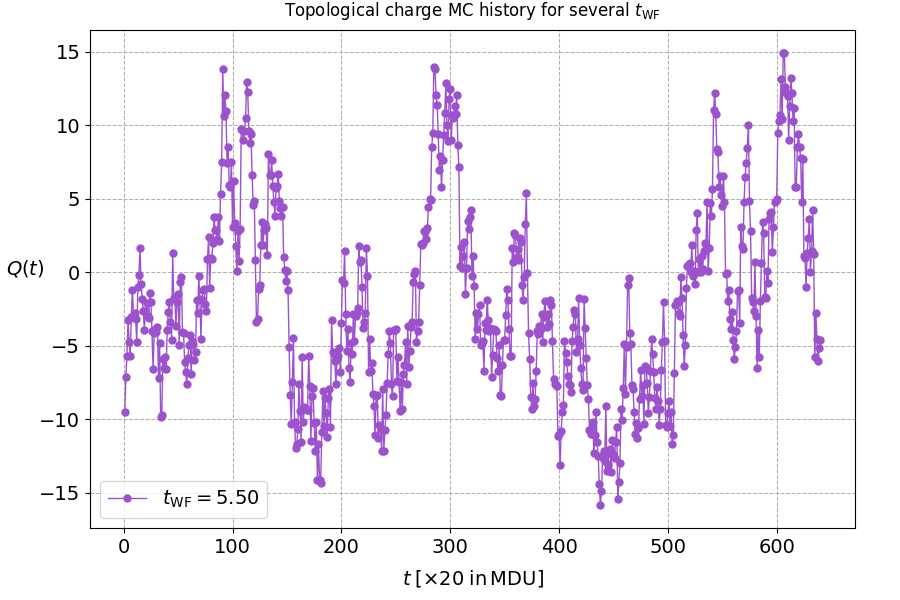

In [8]:
### MC history of Q for several tWF ###

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.10)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(f"Topological charge MC history for several $t_{{\mathrm{{WF}}}}$", pad=10)
ax.set_ylabel(r"$Q(t)$", labelpad=10, rotation=0, fontsize=fsize)
ax.set_xlabel(rf'$t \; [\times {int(MC_step * tauMD)} \; \mathrm{{in \, MDU}}]$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.xlim([-1, 50.5])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

tWF = np.array([1.50, 3.50, 5.50])
i0  = (tWF / (eps_WF * WF_step)).astype(int)
# ax.plot(np.arange(1, Ncnfg+1), np.sum(WF_Q[:, i0[0], :], axis=1), label=rf'$t_{{\mathrm{{WF}}}} = {tWF[0]}$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
# ax.plot(np.arange(1, Ncnfg+1), np.sum(WF_Q[:, i0[1], :], axis=1), label=rf'$t_{{\mathrm{{WF}}}} = {tWF[1]:.2f}$', linestyle='-', marker='o' , markersize=5.0, color='#2bad4e', linewidth=1.0)
ax.plot(np.arange(1, Ncnfg+1), np.sum(WF_Q[:, i0[2], :], axis=1)/V, label=rf'$t_{{\mathrm{{WF}}}} = {tWF[2]:.2f}$', linestyle='-', marker='o' , markersize=5.0, color='#9b52cc', linewidth=1.0)

ax.legend(loc='best', fontsize=fsize)
#plt.savefig("tau_int.pdf")

In [9]:
### Compute <Q^2>_t and tau_int ###
obsQ2 = pyobs.observable(description=f'Topological susceptibility at several WF times')
obsQ2.create('Ensemble A', ((np.sum(WF_Q, axis=2))**2).flatten(), shape=(Nwf,))
obsQ2 /= V**2

print(*(f"(t = {t_WF[i]:.2f}) :    <Q^2> = {obsQ2[i]}                 tau_int = {obsQ2[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsQ2[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :    <Q^2> = 41.8(2.3)
                 tau_int = 0.465 +- 0.064

(t = 0.10) :    <Q^2> = 23.8(1.3)
                 tau_int = 0.564 +- 0.089

(t = 0.20) :    <Q^2> = 20.9(1.8)
                 tau_int = 1.644 +- 0.390

(t = 0.30) :    <Q^2> = 24.4(3.0)
                 tau_int = 3.566 +- 1.128

(t = 0.40) :    <Q^2> = 28.6(4.1)
                 tau_int = 5.075 +- 1.839

(t = 0.50) :    <Q^2> = 31.9(4.8)
                 tau_int = 5.801 +- 2.199

(t = 0.60) :    <Q^2> = 34.4(5.3)
                 tau_int = 6.111 +- 2.367

(t = 0.70) :    <Q^2> = 36.1(5.6)
                 tau_int = 6.248 +- 2.470

(t = 0.80) :    <Q^2> = 37.5(5.8)
                 tau_int = 6.366 +- 2.516

(t = 0.90) :    <Q^2> = 38.5(6.0)
                 tau_int = 6.443 +- 2.547

(t = 1.00) :    <Q^2> = 39.4(6.2)
                 tau_int = 6.492 +- 2.566

(t = 1.10) :    <Q^2> = 40.1(6.2)
                 tau_int = 6.466 +- 2.607

(t = 1.20) :    <Q^2> = 40.7(6.3)
                 tau_int = 6.483 +- 2.613


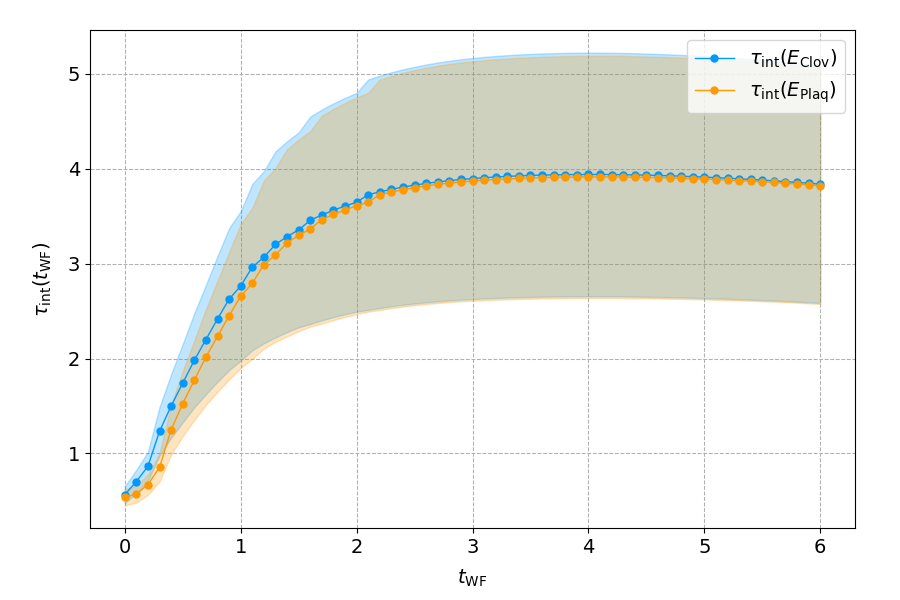

In [10]:
tau_EClov = np.array([np.squeeze(obsEClov[i].tauint()['Ensemble A'], axis=1) for i in range(Nwf)])
tau_EPlaq = np.array([np.squeeze(obsEPlaq[i].tauint()['Ensemble A'], axis=1) for i in range(Nwf)])
tau_Q     = np.array([np.squeeze(obsQ[i].tauint()['Ensemble A'],     axis=1) for i in range(Nwf)])
tau_Q2    = np.array([np.squeeze(obsQ2[i].tauint()['Ensemble A'],    axis=1) for i in range(Nwf)])


fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.10)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_ylabel(r"$\tau_\mathrm{int}(t_\mathrm{WF})$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t_\mathrm{WF}$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.xlim([-1, 50.5])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(t_WF, tau_EClov[:,0], label=r'$\tau_\mathrm{int}(E_\mathrm{Clov})$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(t_WF, tau_EClov[:,0] + std * tau_EClov[:,1], tau_EClov[:,0] - std * tau_EClov[:,1], alpha=.25, color='#0099ff')
ax.plot(t_WF, tau_EPlaq[:,0], label=r'$\tau_\mathrm{int}(E_\mathrm{Plaq})$', linestyle='-', marker='o' , markersize=5.0, color='#ff9900', linewidth=1.0)
ax.fill_between(t_WF, tau_EPlaq[:,0] + std * tau_EPlaq[:,1], tau_EPlaq[:,0] - std * tau_EPlaq[:,1], alpha=.25, color='#ff9900')
# ax.plot(t_WF, tau_Q[:,0], label=r'$\tau_\mathrm{int}(Q)$', linestyle='-', marker='o' , markersize=5.0, color='#a151bf', linewidth=1.0)
# ax.fill_between(t_WF, tau_Q[:,0] + std * tau_Q[:,1], tau_Q[:,0] - std * tau_Q[:,1], alpha=.25, color='#a151bf')
# ax.plot(t_WF, tau_Q2[:,0], label=r'$\tau_\mathrm{int}(Q^2)$', linestyle='-', marker='o' , markersize=5.0, color='#d13e27', linewidth=1.0)
# ax.fill_between(t_WF, tau_Q2[:,0] + std * tau_Q2[:,1], tau_Q2[:,0] - std * tau_Q2[:,1], alpha=.25, color='#d13e27')

ax.legend(loc='best', fontsize=fsize)
#plt.savefig("tau_int.pdf")

In [11]:
### Compute t^2<E> for each t_WF ###
obs_t2EClov = (t_WF[1:]**2) * obsEClov[1:]
obs_t2EPlaq = (t_WF[1:]**2) * obsEPlaq[1:]
print("\n")
print(*(f"(t = {t_WF[i+1]:.2f}) :   t^2 <E_Clov> = {obs_t2EClov[i]}               t^2 <E_Plaq> = {obs_t2EPlaq[i]}\n" for i in range(WF_evol // WF_step)), sep='')



(t = 0.10) :   t^2 <E_Clov> = 0.01373098(33)
               t^2 <E_Plaq> = 0.0605397(11)

(t = 0.20) :   t^2 <E_Clov> = 0.0343975(15)
               t^2 <E_Plaq> = 0.1047972(35)

(t = 0.30) :   t^2 <E_Clov> = 0.0493390(37)
               t^2 <E_Plaq> = 0.1151846(62)

(t = 0.40) :   t^2 <E_Clov> = 0.0593586(65)
               t^2 <E_Plaq> = 0.1141953(98)

(t = 0.50) :   t^2 <E_Clov> = 0.0666971(99)
               t^2 <E_Plaq> = 0.111658(14)

(t = 0.60) :   t^2 <E_Clov> = 0.072672(14)
               t^2 <E_Plaq> = 0.110209(18)

(t = 0.70) :   t^2 <E_Clov> = 0.077929(19)
               t^2 <E_Plaq> = 0.110147(23)

(t = 0.80) :   t^2 <E_Clov> = 0.082781(24)
               t^2 <E_Plaq> = 0.111205(29)

(t = 0.90) :   t^2 <E_Clov> = 0.087389(30)
               t^2 <E_Plaq> = 0.113071(35)

(t = 1.00) :   t^2 <E_Clov> = 0.091841(36)
               t^2 <E_Plaq> = 0.115500(43)

(t = 1.10) :   t^2 <E_Clov> = 0.096191(44)
               t^2 <E_Plaq> = 0.118323(50)

(t = 1.20) :   t^2 <E_Clov> = 0

In [12]:
### Calculation of t_0 for both E_Clov and E_Plaq ###
eps = 0.008

x, dx = obs_t2EClov.error()
idx_x = np.squeeze(np.where((x < 0.3 + eps) & (x > 0.3 - eps)), axis=0)
print(f"\nE_Clov  :")
print(f"                  E_Clov  =  {x[idx_x]},") 
print(f"                  t_WF    =  {t_WF[idx_x+1]},\n") # recall t_WF starts from 0.0, whose corresponding value is not neither in obs_t2EClov nor in obs_t2EPlaq.
interp_Clov = pyobs.interpolate(t_WF[idx_x+1], obs_t2EClov[idx_x])
obs_t0EClov = interp_Clov.solve(0.3, bracket=[t_WF[(idx_x+1)[0]], t_WF[(idx_x+1)[-1]]])
print(f"                  interpolation  --->  t0 = {obs_t0EClov}")
t0_EClov, dt0_EClov = np.squeeze(obs_t0EClov.error(), axis=1)

y, dy = obs_t2EPlaq.error()
idx_y = np.squeeze(np.where((y < 0.3 + eps) & (y > 0.3 - eps)), axis=0)
print(f"E_Plaq  :")
print(f"                  E_Plaq  =  {y[idx_y]},") 
print(f"                  t_WF    =  {t_WF[idx_y+1]},\n")
interp_Plaq = pyobs.interpolate(t_WF[idx_y+1], obs_t2EPlaq[idx_y])
obs_t0EPlaq = interp_Plaq.solve(0.3, bracket=[t_WF[(idx_y+1)[0]], t_WF[(idx_y+1)[-1]]])
print(f"                  interpolation  --->  t0 = {obs_t0EPlaq}")
t0_EPlaq, dt0_EPlaq = np.squeeze(obs_t0EPlaq.error(), axis=1)


E_Clov  :
                  E_Clov  =  [0.29407953 0.29932603 0.30460264],
                  t_WF    =  [5.4 5.5 5.6],

                  interpolation  --->  t0 = 5.513(14)

E_Plaq  :
                  E_Plaq  =  [0.29259965 0.29790975 0.30325426],
                  t_WF    =  [5.  5.1 5.2],

                  interpolation  --->  t0 = 5.139(13)



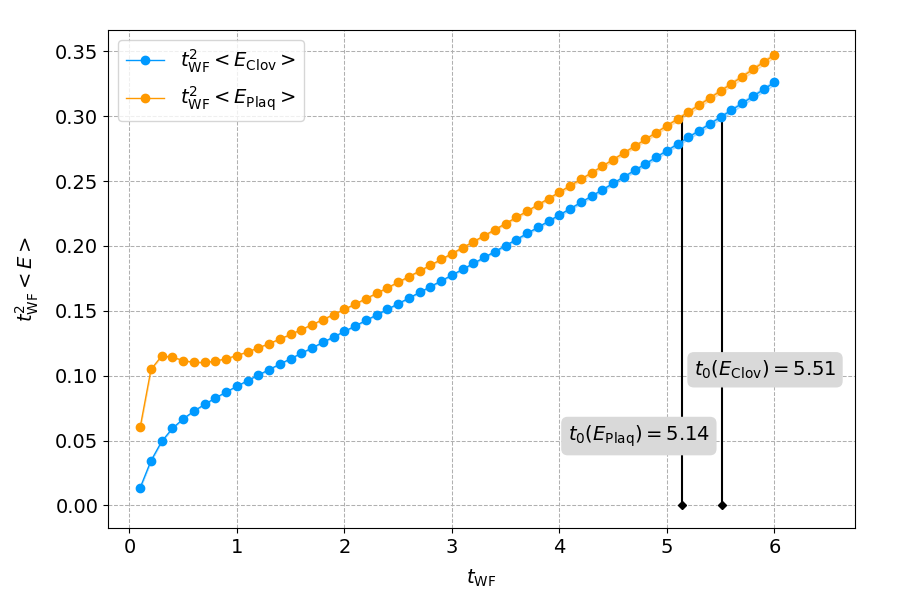

In [13]:
t2EClov = np.array([np.squeeze(obs_t2EClov[i].error(), axis=1) for i in range(WF_evol // WF_step)])
t2EPlaq = np.array([np.squeeze(obs_t2EPlaq[i].error(), axis=1) for i in range(WF_evol // WF_step)])

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.12)
plt.subplots_adjust(right  = 0.95)

fsize = 14
std = 2.0
box = dict(boxstyle="round", color='#d9d9d9')

ax.set_ylabel(r"$t_\mathrm{WF}^2 <E>$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t_\mathrm{WF}$', labelpad=8, fontsize=fsize)

ax.vlines(x = t0_EClov, ymin = 0, ymax = 0.3, colors = 'black', linewidth=1.5)
#ax.scatter(t0_EClov, 0.0, color='black', marker='D', s=12.5)
ax.errorbar(t0_EClov, 0.0, xerr=std*dt0_EClov, color='black', marker='D', markersize=4)
ax.annotate(rf"$t_0(E_\mathrm{{Clov}}) = {t0_EClov:.2f}$", (t0_EClov, 0.10), xytext=(t0_EClov+0.4, 0.10), ha='center', bbox=box, fontsize=fsize)
ax.vlines(x = t0_EPlaq, ymin = 0, ymax = 0.3, colors = 'black', linewidth=1.5)
#ax.scatter(t0_EPlaq, 0.0, color='black', marker='D', s=12.5)
ax.errorbar(t0_EPlaq, 0.0, xerr=std*dt0_EPlaq, color='black', marker='D', markersize=4)
ax.annotate(rf"$t_0(E_\mathrm{{Plaq}}) = {t0_EPlaq:.2f}$", (t0_EPlaq, 0.10), xytext=(t0_EPlaq-0.4, 0.05), ha='center', bbox=box, fontsize=fsize)


plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlim([-0.2, 6.75])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

ax.plot(t_WF[1:], t2EClov[:,0], label=r'$t_\mathrm{WF}^2 <E_\mathrm{Clov}>$', linestyle='-', marker='o' , markersize=6.0, color='#0099ff', linewidth=1.0)
ax.fill_between(t_WF[1:], t2EClov[:,0] + std * t2EClov[:,1], t2EClov[:,0] - std * t2EClov[:,1], alpha=.25, color='#0099ff')
ax.plot(t_WF[1:], t2EPlaq[:,0], label=r'$t_\mathrm{WF}^2 <E_\mathrm{Plaq}>$', linestyle='-', marker='o' , markersize=6.0, color='#ff9900', linewidth=1.0)
ax.fill_between(t_WF[1:], t2EPlaq[:,0] + std * t2EPlaq[:,1], t2EPlaq[:,0] - std * t2EPlaq[:,1], alpha=.25, color='#ff9900')

ax.legend(loc='best', fontsize=fsize)
#plt.savefig('t0E.pdf')

In [14]:
### Compute correlator <q(t)q(0)> for a given tWF. ###
t0 = 5.50
i0 = int(t0 / (eps_WF * WF_step))
QQ = np.zeros((Ncnfg, T))
for tp in range(T):
    QQ[:,tp] = np.mean(WF_Q[:,i0,:] * np.roll(WF_Q[:,i0,:], -tp, axis=1), axis=1) 

obsCorr_QQ = pyobs.observable(description=f'Correlator <q(t)q(0)> for tWF = {t0}')
obsCorr_QQ.create('Ensemble A', QQ.flatten(), shape=(T,))
obsCorr_QQ /= (V*T**2)
#obsCorr_QQ -= V*pyobs.tile(obsQ[i0], T)
print(obsCorr_QQ)
print(obsQ[i0])

48.7(2.2)	45.4(2.1)	37.3(2.0)	27.3(1.9)	18.1(1.8)	10.9(1.7)	6.1(1.6)	3.1(1.5)	1.6(1.4)	0.8(1.3)	0.6(1.2)	0.5(1.2)	0.6(1.1)	0.7(1.1)	0.8(1.2)	0.9(1.2)	1.0(1.3)	1.2(1.3)	1.5(1.3)	1.8(1.3)	2.1(1.4)	2.2(1.5)	2.0(1.6)	1.7(1.7)	1.1(1.8)	0.5(1.8)	-0.1(1.8)	-0.7(1.9)	-1.2(2.0)	-1.5(2.1)	-1.7(2.3)	-1.7(2.5)	-1.8(2.5)	-1.7(2.5)	-1.7(2.3)	-1.5(2.1)	-1.2(2.0)	-0.7(1.9)	-0.1(1.8)	0.5(1.8)	1.1(1.8)	1.7(1.7)	2.0(1.6)	2.2(1.5)	2.1(1.4)	1.8(1.3)	1.5(1.3)	1.2(1.3)	1.0(1.3)	0.9(1.2)	0.8(1.2)	0.7(1.1)	0.6(1.1)	0.5(1.2)	0.6(1.2)	0.8(1.3)	1.6(1.4)	3.1(1.5)	6.1(1.6)	10.9(1.7)	18.1(1.8)	27.3(1.9)	37.3(2.0)	45.4(2.1)

-2.0(1.6)



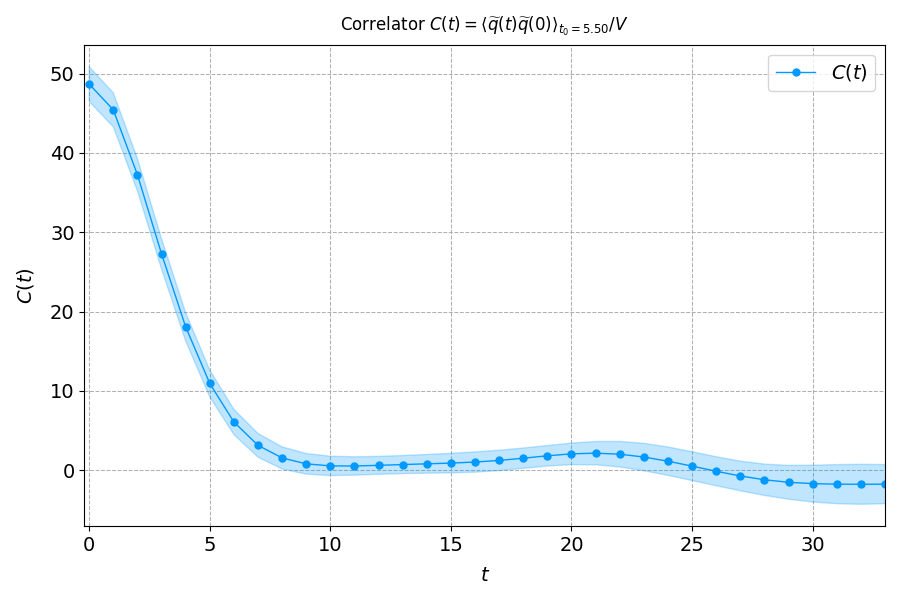

In [15]:
Ct, dCt = obsCorr_QQ.error()

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"Correlator $C(t) = \langle \widetilde{{q}}(t) \widetilde{{q}}(0) \rangle_{{t_0 = {t0:.2f}}} / V$", pad=10)
ax.set_ylabel(r"$C(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-0.2, T/2+1])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(np.arange(T), Ct, label=r'$C(t)$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(T), Ct + std * dCt, Ct - std * dCt, alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [16]:
Tsym = T // 2

obsChi_sum  = 0
Chi_sum     = np.zeros((2, Tsym + 1)) # error and central value

Chi_sum[0, 0]  = obsCorr_QQ[0].error()[0][0]
Chi_sum[1, 0]  = obsCorr_QQ[0].error()[1][0]
for t in range(1, Tsym + 1):
    obsChi_sum  += 2.0 * obsCorr_QQ[t]
    Chi_sum[0, t] = obsChi_sum.error()[0][0]
    Chi_sum[1, t] = obsChi_sum.error()[1][0]

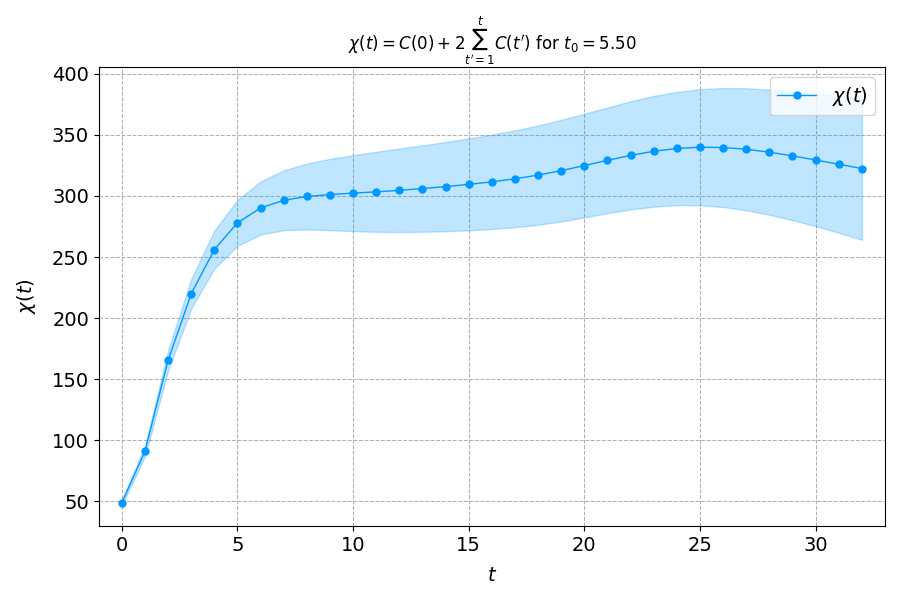

In [17]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"$\chi(t) = C(0) + 2\sum_{{t'=1}}^t C(t')$ for $t_0 = {t0:.2f}$")
ax.set_ylabel(r"$\chi(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-1, T/2+1])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(np.arange(Tsym + 1), Chi_sum[0], label=r'$\chi(t)$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(Tsym + 1), Chi_sum[0] + std * Chi_sum[1], Chi_sum[0] - std * Chi_sum[1], alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [18]:
t0 = 5.50
i0 = int(t0 / (eps_WF * WF_step))
EEClov = np.zeros((Ncnfg, T))
EClov  = np.zeros((Ncnfg, T))
for tp in range(T):
    EEClov[:,tp] = np.mean(WF_EClov[:,i0,:] * np.roll(WF_EClov[:,i0,:], -tp, axis=1), axis=1)

obsCorr_EEClov = pyobs.observable(description=f'Correlator <E(t)E(0)> for tWF = {t0}')
obsCorr_EEClov.create('Ensemble A', EEClov.flatten(), shape=(T,))
obsCorr_EEClov *= T/V 
obsCorr_EEClov -= pyobs.tile(obsEClov[i0]*obsEClov[i0], T) * V / T
# print(obsCorr_EEClov)
# print(obsEClov[i0]*obsEClov[i0]*V/T)

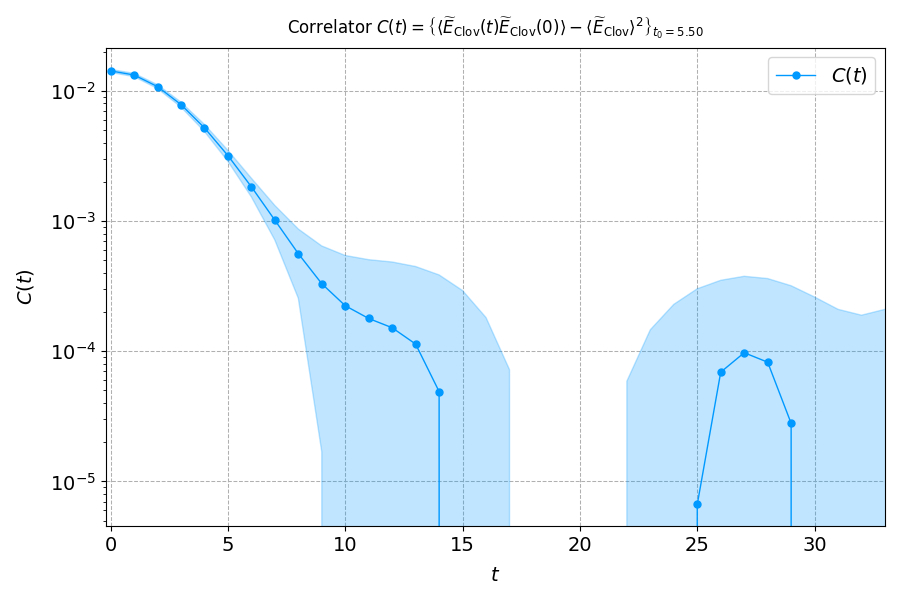

In [19]:
Ct, dCt = obsCorr_EEClov.error()

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"Correlator $C(t) = \left \{{ \langle \widetilde{{E}}_\mathrm{{Clov}}(t) \widetilde{{E}}_\mathrm{{Clov}}(0) \rangle - \langle \widetilde{{E}}_\mathrm{{Clov}} \rangle^2 \right \}}_{{t_0 = {t0:.2f}}}$", pad=10)
ax.set_ylabel(r"$C(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-0.2, T/2+1])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)
ax.set_yscale('log')

std = 1.0
ax.plot(np.arange(T), Ct, label=r'$C(t)$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(T), Ct + std * dCt, Ct - std * dCt, alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [20]:
Tmin = 0
Tmax = T // 2
Ct_mass   = np.zeros(Tmax - Tmin)
dCt_mass  = np.zeros(Tmax - Tmin)

for i in range(Tmax - Tmin):
    eff_mass  = pyobs.log(obsCorr_EEClov[i] / obsCorr_EEClov[i+1])
    Ct_mass[i]   = eff_mass.error()[0][0]
    dCt_mass[i]  = eff_mass.error()[1][0]

/knuthome/gmorandi/gabriele_py/lib64/python3.6/site-packages/pyobs/tensor/unary.py:26: RuntimeWarning: invalid value encountered in log
  new_mean = f(x.mean)


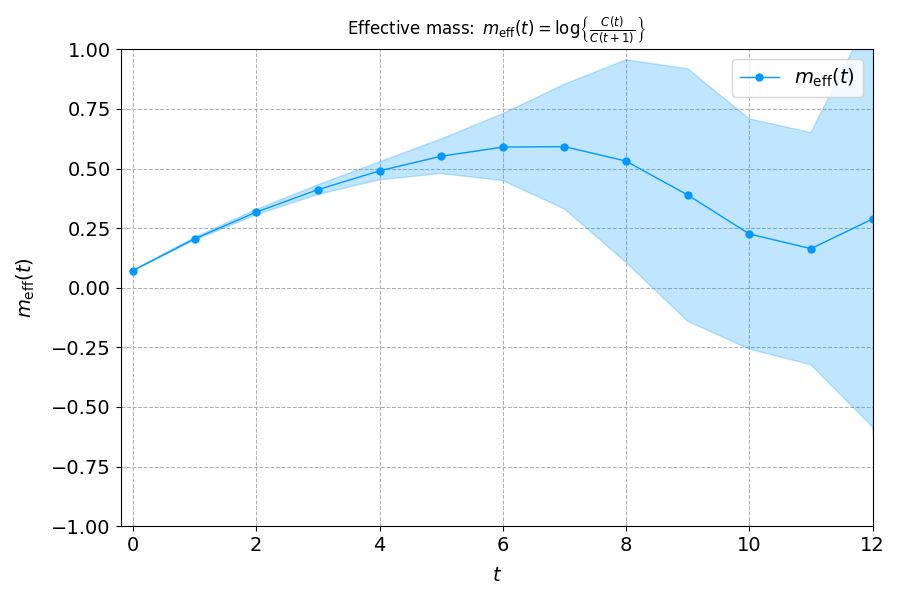

In [21]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"Effective mass: $\,m_\mathrm{{eff}}(t) = \log \left \{{ \frac{{C(t)}}{{C(t+1)}} \right \}}$", pad=10)
ax.set_ylabel(r"$m_{\mathrm{eff}}(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-0.2, 12])
plt.ylim([-1, 1])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(np.arange(Tmin, Tmax), Ct_mass, label=r'$m_{\mathrm{eff}}(t)$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(Tmin, Tmax), Ct_mass + std * dCt_mass, Ct_mass - std * dCt_mass, alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [22]:
### Compute autocorrelation functions for each <E_Clov>_t and <E_Plaq>_t ###
gammaEClov = []
gammaEPlaq = []
gammaQ     = []
gammaQ2    = []
if (obsEClov.shape[0] == Nwf) and (obsEPlaq.shape[0] == Nwf) \
    and (obsQ.shape[0] == Nwf) and (obsQ2.shape[0] == Nwf):
    for i in range(Nwf): 
        norm, gamma = obsEClov[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaEClov.append(gamma)
        norm, gamma = obsEPlaq[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaEPlaq.append(gamma)
        norm, gamma = obsQ[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaQ.append(gamma)
        norm, gamma = obsQ2[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaQ2.append(gamma)
else:
    print(f"Check observables shapes !")

norm, gamma_t0EClov = obs_t0EClov.delta['Ensemble A:0'].gamma(Ncnfg, 0)
gamma_t0EClov = gamma_t0EClov / norm 

norm, gamma_t0EPlaq = obs_t0EPlaq.delta['Ensemble A:0'].gamma(Ncnfg, 0)
gamma_t0EPlaq = gamma_t0EPlaq / norm 

gammaEClov = np.array(gammaEClov)
gammaEPlaq = np.array(gammaEPlaq)
gammaQ     = np.array(gammaQ)
gammaQ2    = np.array(gammaQ2)

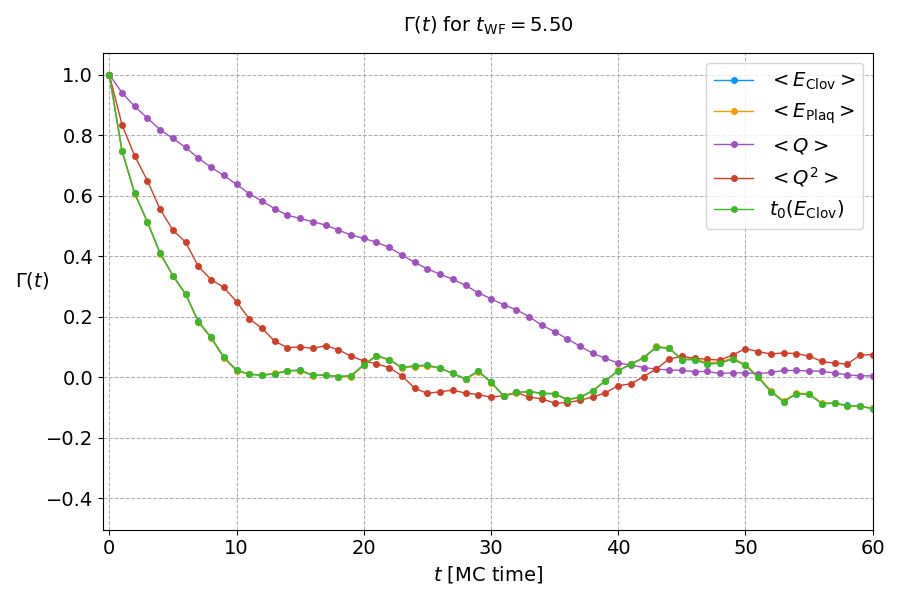

In [23]:
fig, ax = plt.subplots(figsize=(9, 6))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)
fsize = 14

tmax = Ncnfg // 4
t = 5.50
i = int(t / (eps_WF * WF_step)) 

plt.title(rf'$\Gamma(t)$ for $t_\mathrm{{WF}}={t:.2f}$', pad=15, fontsize=fsize)

ax.plot(np.arange(tmax), gammaEClov[i,:tmax]/gammaEClov[i,0], color='#0099ff', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<E_\mathrm{{Clov}}>$')
ax.plot(np.arange(tmax), gammaEPlaq[i,:tmax]/gammaEPlaq[i,0], color='#ff9900', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<E_\mathrm{{Plaq}}>$')
ax.plot(np.arange(tmax), gammaQ[i,:tmax]/gammaQ[i,0], color='#a151bf', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<Q>$')
ax.plot(np.arange(tmax), gammaQ2[i,:tmax]/gammaQ2[i,0], color='#d13e27', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<Q^2>$')
ax.plot(np.arange(tmax), gamma_t0EClov[:tmax]/gamma_t0EClov[0], color='#3cba25', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$t_0(E_\mathrm{{Clov}})$')
ax.set_xlabel(r'$t$ [MC time]', fontsize=fsize)
ax.set_ylabel(r'$\Gamma(t)$', rotation=0, labelpad=10, fontsize=fsize)
ax.legend(loc='best', fontsize=fsize)


plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlim([-0.5, 60])
#plt.ylim([1e-2, 1e1])
#ax.set_yscale('log', base=10)
#ax.set_xscale('log', base=10)
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

Bounding Method application

In [24]:
### Bounding Method ###
t0 = 5.50
i0 = int(t0 / (eps_WF * WF_step))
tau0 = obsQ[i0].tauint()['Ensemble A'][0][0]
print(f"\n tau_slow for bounding = {tau0:.2f}, which is {int(tau0 * tauMD * MC_step)} MDU\n")

Tmax = 40
for t in range(Tmax):
   # print(f" t0     :    tau_eff(W={t}) = {1.0 / np.log(gamma_t0EClov[t] / gamma_t0EClov[t+1]):.3f},")
   print(f" Q      :    tau_eff(W={t}) = {1.0 / np.log(gammaQ[i0, t] / gammaQ[i0, t+1]):.3f},")
   # print(f" Q^2   :    tau_eff(W={t}) = {1.0 / np.log(gammaQ2[i0, t] / gammaQ2[i0, t+1]):.3f},")
print("\n")


 tau_slow for bounding = 18.71, which is 374 MDU

 Q      :    tau_eff(W=0) = 16.150,
 Q      :    tau_eff(W=1) = 20.137,
 Q      :    tau_eff(W=2) = 22.748,
 Q      :    tau_eff(W=3) = 21.712,
 Q      :    tau_eff(W=4) = 28.197,
 Q      :    tau_eff(W=5) = 25.906,
 Q      :    tau_eff(W=6) = 20.879,
 Q      :    tau_eff(W=7) = 23.735,
 Q      :    tau_eff(W=8) = 24.951,
 Q      :    tau_eff(W=9) = 22.278,
 Q      :    tau_eff(W=10) = 20.139,
 Q      :    tau_eff(W=11) = 24.310,
 Q      :    tau_eff(W=12) = 22.563,
 Q      :    tau_eff(W=13) = 25.447,
 Q      :    tau_eff(W=14) = 48.986,
 Q      :    tau_eff(W=15) = 49.558,
 Q      :    tau_eff(W=16) = 45.391,
 Q      :    tau_eff(W=17) = 30.085,
 Q      :    tau_eff(W=18) = 28.766,
 Q      :    tau_eff(W=19) = 41.605,
 Q      :    tau_eff(W=20) = 36.106,
 Q      :    tau_eff(W=21) = 25.210,
 Q      :    tau_eff(W=22) = 16.885,
 Q      :    tau_eff(W=23) = 15.773,
 Q      :    tau_eff(W=24) = 17.223,
 Q      :    tau_eff(W=25) = 19.77

In [25]:
def Cbar_W(gamma, W):
    """ returns Cbar(W) = gamma(0) + 2*sum_i=1^W gamma(i) """
    return gamma[0] + 2.0 * np.sum(gamma[1:W+1])

def sys_err(gammaW, W, tau_slow, tau_effW):
    """ returns the systematic effect coming from the truncation 
    of the sum of the autocorrelation function up to a window W. 
    This quantity is computed in a data-driven way, i.e. the error is 
    is given by a difference between the bounds (see eqs 4.2.1 master thesis),
    namely
        2*sum_{i=W+1}^infty{ gamma_upp(t|W, tau0) - gamma_low(t|W, tau_eff^W) }
    """
    cutoff_low = int(np.ceil(3.0 * tau_effW * np.log(10)))
    cutoff_upp = int(np.ceil(3.0 * tau_slow * np.log(10)))
    if cutoff_upp < W:
        cutoff_upp *= 2
    if cutoff_low < W:
        cutoff_low *= 2
    sum_upp = np.sum(np.exp(- (np.arange(cutoff_upp - W) + 1) / tau_slow))
    sum_low = np.sum(np.exp(- (np.arange(cutoff_low - W) + 1) / tau_effW))
    return 2.0 * gammaW * (sum_upp - sum_low)

In [26]:
########################
### Bounding routine ###
########################
# gamma is a numpy array of size Nconf containing the values of the
# autocorrelation function for a given observable. 
def bounding(gamma, tau_slow, M=2.0):
    W = 0
    # Assume first W is ok by default:
    arg_o     = gamma[W] / gamma[W + 1]
    tau_eff_o = 1.0 / np.log(arg_o)
    LHS_o     = np.sqrt((4.0 * W + 2.0) / Ncnfg)
    cbar_o    = Cbar_W(gamma, W)      # this is only gamma[0] for W = 0
    RHS_o     = M * sys_err(gamma[W], W, tau_slow, tau_eff_o) / cbar_o
    print(f"\n slowest mode = {tau_slow}\n")
    print(f" W = {W},  tau_eff^W = {tau_eff_o},  LHS - RHS = {LHS_o - RHS_o},  err = {cbar_o}")
    W = 1
    while W < Ncnfg:
        arg_n = gamma[W] / gamma[W + 1]
        if (arg_n <= 1.0) or (1.0/np.log(arg_n) >= tau_slow):
            arg_n = arg_o # uses the last tau_eff that is ok
            
        tau_eff_n = 1.0 / np.log(arg_n)
        LHS_n     = np.sqrt((4.0 * W + 2.0) / Ncnfg)
        cbar_n    = Cbar_W(gamma, W)
        RHS_n     = M * sys_err(gamma[W], W, tau_slow, tau_eff_n) / cbar_n
        
        print(f" W = {W},  tau_eff^W = {tau_eff_n},  LHS - RHS = {LHS_n - RHS_n},  err = {cbar_n}")

        if ((LHS_o - RHS_o < 0.0) and (LHS_n - RHS_n >= 0.0)): # change of sign with current W --> return new.
            return W
        elif ((LHS_o - RHS_o < 0.0) and (LHS_n - RHS_n < 0.0)): # not yet change of sign. 
            arg_o, LHS_o, RHS_o, cbar_o  = arg_n, LHS_n, RHS_n, cbar_n
            W += 1
        else: # both differences are positive
            print(f"Both differences at {W} and {W+1} are positive.")
            if (LHS_o - RHS_o) > (LHS_n - RHS_n):
                arg_o, LHS_o, RHS_o, cbar_o  = arg_n, LHS_n, RHS_n, cbar_n
                W += 1
            else:
                return W-1
gamma = gamma_t0EClov              
#gamma = gammaQ[i0, :]
#gamma = gammaQ2[i0, :]

print(f"\n W_bnd = {bounding(gamma, 3*tau0, M=2.0)}")


 slowest mode = 56.126744995641985

 W = 0,  tau_eff^W = 3.4588804015566565,  LHS - RHS = -210.3154624330344,  err = 0.015724419926168513
 W = 1,  tau_eff^W = 4.784013076518487,  LHS - RHS = -61.39778561422258,  err = 0.0392773728302946
 W = 2,  tau_eff^W = 5.893145404187972,  LHS - RHS = -32.716720881395304,  err = 0.058387562289377255
 W = 3,  tau_eff^W = 4.450743304291368,  LHS - RHS = -22.19143864144094,  err = 0.07451517701901561
 W = 4,  tau_eff^W = 5.024211961352144,  LHS - RHS = -14.87801277934108,  err = 0.087397440377151
 W = 5,  tau_eff^W = 5.001097661916303,  LHS - RHS = -10.82105051412922,  err = 0.09795471587722634
 W = 6,  tau_eff^W = 2.493761191022411,  LHS - RHS = -8.484021404920368,  err = 0.1065986614314206
 W = 7,  tau_eff^W = 3.000319828646157,  LHS - RHS = -5.2492587349147675,  err = 0.11238707600858444
 W = 8,  tau_eff^W = 1.4480515760442045,  LHS - RHS = -3.6622904450701945,  err = 0.11653480366916494
 W = 9,  tau_eff^W = 0.960626160999065,  LHS - RHS = -1.6852